<h1><span style="color:red">Esse estudo não é uma recomendação de compra ou de estratégia de investimento. Seu objetivo é unicamente exemplificar habilidades analíticas em meu Portifólio.</span></h1>

<hr>
<h1> <strong>Estudo sobre estratégia "Cruzamento entre as médias".</strong></h1>
<hr>

<h2> <strong>Descrição da Estratégia:</strong></h2>

É bastante comum a utilização de médias móveis para determinar os pontos de compra e venda de ações.

A idéia é utilizar duas médias, uma média rápida e uma média lenta, e os pontos de cruzamento entre essas médias para determinarmos quando comprar ou vender as ações.


Na figura abaixo vemos um exemplo da média movel exponencial (MME) de 9 períodos (MME9) atuando como a média rápida, e a média móvel aritimética (MMA) de 21 períodos (MMA21) como a média lenta. Os pontos de compra são definidos pelo cruzamento das duas médias, com a média rápida cruzando a média lenta de baixo para cima (círculos vermelhos). Os pontos de venda, por sua vez, são identificados pelo cruzamento, de cima para baixo, da média rápida em relação à média lenta (quadrados pretos). Com essa regra, quando ocorre o cruzamento das média, compramos ou vendemos no fechamento do pregão daquele dia.

![Logo do R](Fig_Ponto_Compra_Venda_Medias_Moveis.png)



<h3> <strong>Objetivo do estudo:</strong> </h3>

- Determinar quais os períodos das médias rápida e lenta que maximizam o capital acumulado, partindo-se de um capital inicial de R$1000,00 reais;

<hr>
<h3>
Vamos importar as bibliotecas necessárias;


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from datetime import datetime
import math
from sklearn.cluster import KMeans


<hr>
<h3>Obtenho os dados de preços com a biblioteca yfinance, desde o ano de 2000 até o presente.</h3>

Tomo como exemplo as ações da Copel (CPLE6).

[*********************100%***********************]  1 of 1 completed


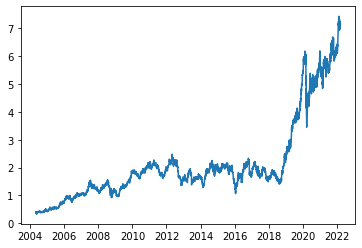

In [2]:
dataINI="2004-05-01"  # Data inicial dos dados;
Papel='CPLE6.SA'      # Defino aqui o ticker da empresa analisada;
dataFIM=datetime.today().strftime('%Y-%m-%d')

def get_data(dataINI,dataFIM,Papel):
    df = yf.download(Papel, start=dataINI, end=dataFIM).copy()[["Open", "High", "Low", "Adj Close"]]
    df.dropna(inplace=True)
    df['Close']=df['Adj Close']#.rolling(window=5).mean()
    df.head()
    return df

df=get_data(dataINI,dataFIM,Papel)
df.head()
plt.plot(df['Close'])

<hr>
<h3>Defino abaixo as funções para calcular a média móvel aritimética e exponencial;

In [3]:
#============================================================
def MME(prices, dias, suavize=2):
    ema = np.empty((dias-1))
    ema[:] = np.NaN
    #print(ema)
    ema=np.append(ema,[sum(prices[:dias]) / dias])
    for price in prices[dias:]:
        ema=np.append(ema,(price * (suavize / (1 + dias))) + ema[-1] * (1 - (suavize / (1 + dias))))
    return ema
#============================================================
#============================================================
def MMA(prices, dias):
    mma = np.empty((dias-1))
    mma[:] = np.NaN
#    mma=np.append(mma,[sum(prices[:dias]) / dias])
    for dia in range(dias,len(prices)+1):
#        print(dias,dia,len(prices))
        mma=np.append(mma,prices[dia-dias:dia].sum()/dias)
    return mma
#============================================================

<hr>
<h3> Função para executar a estratégia de compra/venda:</h3>

    - Compro: quando a MME(Períodos=PA) fechar acima da MMA(Períodos=PB) pela primeira vez;
    - Vendo:  quando a MME(Períodos=PA) fechar abaixo da MMA(Períodos=PB) pela primeira vez;
                                     

In [87]:
def run_strategy(dfin,PA,PB,Controle_de_Risco):
    comprado=False
   # print('Controle de risco em %i ' % Controle_de_Risco)
    Capital_inicial=1000
    Capital=  np.zeros(len(dfin))  
    Capital[:]=Capital_inicial
    #print(dfin.head())
    Result = np.empty(len(dfin))
    Result[:] = np.NaN

    Ops=np.zeros([len(dfin),2])
    Ops[:]=np.NaN
    price=np.array(dfin['Close'])
    MA=np.array(MME(dfin['Close'],PA))
    MB=np.array(MMA(dfin['Close'],PB))
    
   # dm80=np.array(df['DistMMA80'])
    j=0
    low=np.array(dfin['Low'])
    high=np.array(dfin['High'])
    Open=np.array(dfin['Open'])
    
    gain=0
    loss=0
    nopG=0
    nopL=0
    for i in range(2,len(dfin)):
        if comprado == False:
            Capital[i]=Capital[i-1]
            if MA[i] > MB[i] and MA[i-1] < MB[i-1]  :
                comprado=True
                ii=i
                entry=price[i]
                shares =  int(math.floor(Capital[i] / entry) )
                profit=0
                stop=entry*(1-Controle_de_Risco/100)
           # print(nop,Capital[i],entry,shares)
        else:
            if MA[i] < MB[i] and MA[i-1] > MB[i-1]:
                exit=price[i]
                profit = shares * (exit - entry)                
                comprado=False
                if profit > 0:
                    nopG+=1
                    gain+=profit
                    Result[ii]=1    # GAIN
                else:            
                    nopL+=1
                    Result[ii]=0    # LOSS
                    loss+=profit
                Ops[j,0]=Capital[i-1]+profit
                Ops[j,1]=profit
                j+=1
        
                    
            elif price[i]<stop:
                exit=price[i]
                profit = shares * (exit - entry)
                #gain+=[profit/entry]
                comprado=False
                Ops[j,0]=Capital[i-1]+profit
                Ops[j,1]=profit
                j+=1

                
            Capital[i]=Capital[i-1] + profit

            
    if nopG != 0:
        MG=gain/nopG
    else:
        MG=np.nan

    if nopL != 0:
        MP=loss/nopL
    else:
        MP=np.nan
        
    if nopG+nopL == 0:
        TA=np.nan
        TE=np.nan
    else:
        TA=nopG/(nopG+nopL)  # Taxa de acerto
        TE=nopL/(nopG+nopL)
        
    EM = TA *MG + TE * MP 
    return Capital[len(Capital)-1],gain,loss,TA,EM,Ops[:,0],Ops[:,1]
            
#CapTot=run_strategy(df,np.array(df['MME9']),np.array(df['MMA21']),5)
#    m21=np.array(df['MMA21'])
#    me9=np.array(df['MME9'])

<hr>

Vou executar a estratégia, variando o período da média rápida de 1 até nPA=100, e a variando a média lenta de 1 a nPB=200.
    

Essa estratégia é comumente usada sem <strong>STOP</strong>, contudo, mantenho a perda máxima tolerada por operação igual a 10%. Caso atinja esse valor, vendo no fechamento;

In [90]:
nPA=100
nPB=200
STOP=10 # % de perda máxima admitida. Se alcançar esse valor, vendo no fechamento;

Capital=np.zeros([nPA,nPB])  
Gain=np.zeros([nPA,nPB])  
Loss=np.zeros([nPA,nPB])  
TA=np.zeros([nPA,nPB])  # Taxa de Acerto
EM=np.zeros([nPA,nPB])  # Expectativa Matemática
capital=np.zeros([nPA,nPB,len(df)])  
lucro=np.zeros([nPA,nPB,len(df)])  

for A in range(1,nPA):
    for B in range(1,nPB):
        Capital[A,B],Gain[A,B],Loss[A,B],TA[A,B],EM[A,B],capital[A,B,:],lucro[A,B,:]=run_strategy(df,A,B,STOP)
np.save('Capital_'+Papel+'.npy', Capital)
np.save('Gain_'+Papel+'.npy', Gain)
np.save('Loss_'+Papel+'.npy', Loss)
np.save('TA_'+Papel+'.npy', TA)
np.save('EM_'+Papel+'.npy', EM)
      

<hr>
Caso seja necessário, poderemos carregar os dados obtidos pela estratégia e salvos no passo anterior. Basta executar a célula abaixo!

In [5]:
Capital=np.load('Capital_'+Papel+'.npy')
Gain=np.load('Gain_'+Papel+'.npy')
Loss=np.load('Loss_'+Papel+'.npy')
TA=np.load('TA_'+Papel+'.npy')
EM=np.load('EM_'+Papel+'.npy')


  

<hr>
<h3><strong>Vamos olhar os resultados ... </strong></h3>



4445 (100, 200)


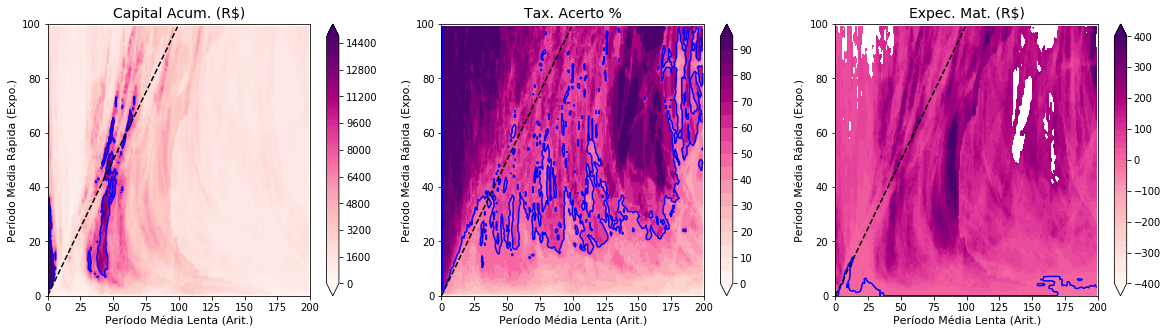

In [6]:
def plot_triade(Capital, TA, EM,TAmax,TBmax):
    i=0
    lev=[np.array(range(0,15000,200)),np.array(range(0,100,5)),np.array(range(-400,420,20)),np.array(range(0,400,50))]
    lev2=[np.array(range(9000,9001,10)),np.array(range(50,51,10)),np.array(range(0,1,100)),np.array(range(200,500,100))]
    title=['Capital Acum. (R$)', 'Tax. Acerto %','Expec. Mat. (R$)']
    features=[Capital,TA*100,EM]
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    for col, ax in zip(features, axs.ravel()):
        cp = ax.contourf(col,cmap='RdPu',extend='both',levels=lev[i])
        ax.contour(col,cmap='winter',levels=lev2[i])
        fig.colorbar(cp,ax=ax) # Add a colorbar to a plot
        ax.set_xlim([0,TBmax])#([15,30])
        ax.set_ylim([0,TAmax])#([20,35])
        ax.set_title(title[i],size=14)
        ax.set_xlabel('Período Média Lenta (Arit.)',size=11)
        ax.set_ylabel('Período Média Rápida (Expo.)',size=11)
        ax.plot(range(0,100),range(0,100),c='black',ls='--')
        i+=1
plot_triade(Capital,TA,EM,100,200)
#print(lev[0])
print(len(df),Capital.shape)

<hr>
<h3><strong>Numa primeira observação, notemos que:</strong></h3>

- Há duas regiões estreitas com totais acumulados bastante significativos (ver contorno de R$5000.00), enquanto o restante produz resultados mínimos;
- As regiões de maior acumulação ocorrem em conformidade com a Expectativa matemática, e não com a taxa de acerto. Esse resultado é esperado para modelos  seguidores de tendência, que possuem lucratividade com baixa taxa de acerto, ancorada em um  ganho médio maior que a perda média.
- O padrão de aumento da expectativa matemática ao se aumentar PA e PB não gera maior acumulo de capital, provavelmente pelo baixo número de operações que se obtém quando se utiliza períodos muito longos.

Vou reduzir a área das figuras para continuar as análises, focando na região de PA<80 e PB<70;

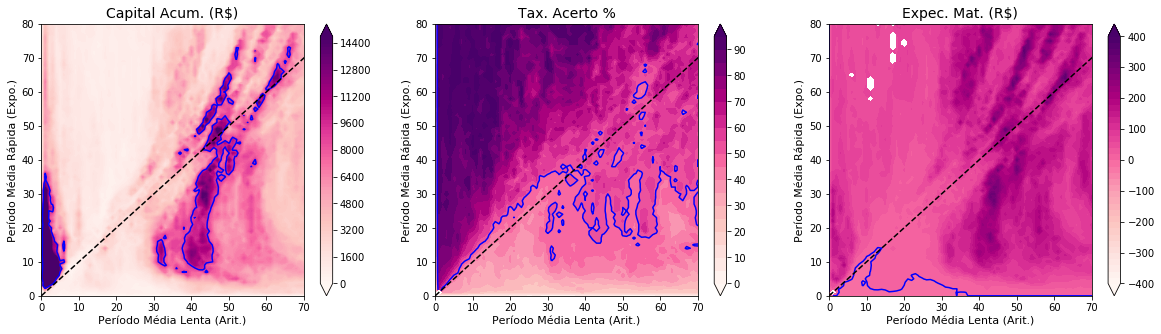

In [7]:
plot_triade(Capital,TA,EM,80,70)

<hr>
<h3><strong>Continuando ....</strong></h3>

- As duas regiões estreitas de maior acumulação apresentam combinações bastante distintas de PA e PB. No na primeira região, temos PA > PB, o que não condiz com a lógica primária por trás da estratégia descrita, uma vez que as médias rápidas e lentas trocaram suas funções. Isso indica que a lucratividade vem de um comportamento inesperado entre a estratégia e os preços. Vamos olhar para a primeira região de acumulação num estudo posterior. Por ora, nos ateremos à segunda região de acumulação.

- A segunda região de maior lucratividade é mais ampla, englobando valores de PA e BP entre 5<PA<70 e 30<PB<80, aproximadamente. Sua distribuição sugere um comportamento não linear, embora um ajuste linear aparentemente possa ser aplicado.


<h1> Pois bem</h1>
Continuando a investigação, seleciono apenas os pontos de PA e PB que resultaram em um ganho mínimo de 900%, e estes pontos serão utilizados como alvo de nosso estudo daqui em diante.  Vamos olhar para os pontos em questão!


Defino antes uma função que nos ajudará a realizar um ajuste linear ou logarítmo. Em seguida, defino uma função para visualizar os pontos de interesse!

In [8]:
def flog(w0,w1,X,f):
    if f=='lin':
        fx=np.array(w0+w1*X)
    elif f=='log':
        fx=np.array([w0+w1*math.log(x,2) for x in X])
    return fx
    

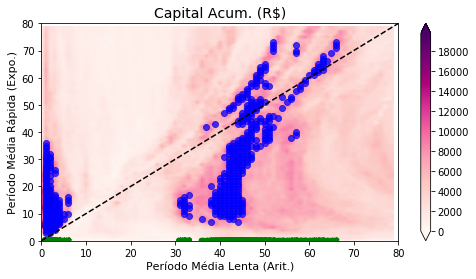

In [9]:
def plot_triade2(Capital, TA, EM,b,w0,w1,f,x,y):
    i=0
    lev=[np.array(range(0,20000,200)),np.array(range(0,100,5)),np.array(range(0,200,20)),np.array(range(0,200,10))]
    lev2=[np.array(range(5000,5001,10)),np.array(range(50,51,10)),np.array(range(600,5000,1000)),np.array(range(200,500,100))]
    #[jj,ii]=np.nonzero(Capital > 9000)

    title=['Capital Acum. (R$)', 'Tax. Acerto %','Expec. Mat. (R$)']
    features=[Capital,TA*100,EM]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
    cp = ax.contourf(Capital,cmap='RdPu',extend='both',levels=lev[i])
   # ax.contour(col,cmap='winter',levels=lev2[i])
    fig.colorbar(cp,ax=ax) # Add a colorbar to a plot
    ax.set_xlim([0,len(Capital[0,:])])#([15,30])
    ax.set_ylim([0,len(Capital[:,0])])#([20,35])
    ax.set_title(title[i],size=14)
    ax.set_xlabel('Período Média Lenta (Arit.)',size=11)
    ax.set_ylabel('Período Média Rápida (Expo.)',size=11)
    ax.plot(range(0,100),range(0,100),c='black',ls='--')
    ax.scatter(x,y,c='blue',Alpha=0.7)#capital=[run_strategy(df,27,24,risk) for risk in range(0,100)]
   # ax.scatter(ii,[w0+w1*math.log(np.array(a),b) for a in ii],c='blue',ls='--')
    ax.scatter(x,flog(w0,w1,x,f),c='green',ls='--')
    
    i+=1
[jj,ii]=np.nonzero(Capital > 9000)
plot_triade2(Capital[:80,:80],TA,EM,2,0,0,'log',ii,jj)

<hr>

Temos aqui os pontos de interesse marcados em azul.
No entanto, estou interessado apenas na segunda região. 

Preciso de uma maneira objetiva para separar essas duas regiões. Como as duas regiões estão bastante distantes entre si, bastaria tomar, por exemplo, o limiar de PB=20 e montar dois conjuntos, um com valores maiores e outro com valores menores de PB.

No entanto, dada a oportunidade, farei a separação das dias regiões utilizando uma técnica de clusterização, que poderia ser utilizada caso não conseguissemos separar as duas regiões de forma tão simples.

Há várias técnicas de clusterização. Nesse caso específico, qualquer uma deve conseguir separar os dados sem maiores problemas.

Uso o K-means que, de forma simplificada:

- Seleciona aleatoriamente valores dentro da amostra, que servirão de médias iniciais na iteração;
- Atribui cada ponto da amostra a um cluster, baseado na distância daquele ponto às médias estabelecidas;
- Calcula os centróides de cada um dos clusters formados e utiliza esses valores como a nova média;
- Repete a atribuição de cada ponto da amostra, utilizando a nova média, e assim consecutivamente, acompanhando a redução da variância dos conjuntos;

Esse procedimento busca minimizar a variância interna de cada cluster, e é um dos procedimentos mais simples dentro dos algoritmos de clusterização. Vejamos abaixo como implementá-lo:


(0, 75)

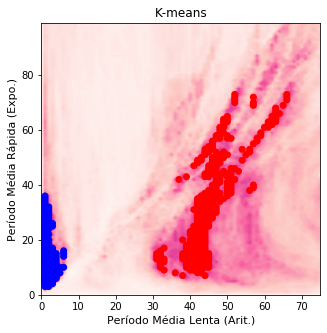

In [86]:
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
[jj,ii]=np.nonzero(Capital > 9000)   # Define a regiao alvo
X=np.array([[A,B] for A,B in zip(ii,jj)])
nc=2
kmeans = KMeans(init="random", n_clusters=nc, n_init=4, random_state=0)
birch = Birch(threshold=0.0001, n_clusters=nc)
gaussian = GaussianMixture(n_components=nc)
meanshift = MeanShift()
model=[kmeans,birch,gaussian,meanshift]

lab=['K-means']#,'Birch', 'GaussianMixture','MeanShift']
cor = ['blue', 'red', 'green','gray','purple','black'] #list(map(lambda x: '#3b4cc0' if x == 1 el '#b40426', P))
i=0
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
#mod,ax in zip(model,axs.ravel()):
model[i].fit(X)
P=model[i].predict(X)
colors=[cor[i] for i in P]
#    cp = ax.contourf(Capital,cmap='RdPu',extend='both',levels=lev[i])
ax.contourf(Capital,cmap='RdPu',extend='both',levels=range(0,15000,200))
ax.scatter(X[:,0], X[:,1], c=colors, marker="o", picker=True)
ax.set_title(lab[i])
ax.set_xlabel('Período Média Lenta (Arit.)',size=11)
ax.set_ylabel('Período Média Rápida (Expo.)',size=11)
ax.set_xlim([0,75])
#print(P)
    


<hr>
A técnica de clusterização separou os dois grupos com sucesso. Preciso ainda utilizar essa classificação para extrair apenas os dados de interesse. Faço isso agora:

In [11]:
def initiate2(Xin,P):
    X=np.array([Xin[i,0] for i in range(0,len(Xin)) if P[i] ==0])
    y=np.array([Xin[i,1] for i in range(0,len(Xin)) if P[i] ==0])
    return  X, y

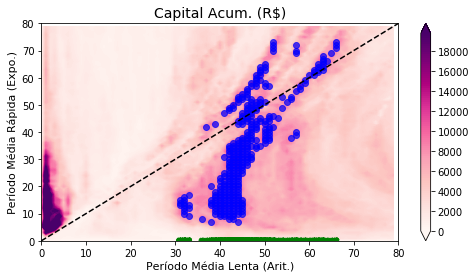

In [14]:
x, y = initiate2(X,P)
plot_triade2(Capital[:80,:80],TA,EM,2,0,0,'lin',x,y)


<h1>Pois bem</h1>

Separamos os grupos pela técnica de clusterização e selecionamos apenas a região de interesse. 

Vamos <strong>ajustar uma função aos dados</strong> para descrever qual Média Rápida (PA) devemos usar, dado um certo PB contido em 30<PB<65.



Tentarei ajustar aos resultados de Capital Acumulado duas curvas:

- <strong>Ajuste linear:</strong> $PA=B_0+A*PB$

- <strong>ajuste logarítmico:</strong> $PA=B_0+A*log(PB)$





com:

- PA: Período da média rápida;
- PB: Período da média lenta;
- logaritmo de base 2;
- Bo: coeficiente linear do ajuste
- A: coeficiente angular

O objetivo será então ajustar uma reta e uma curva logaritmica aos pontos em azul abaixo:

<hr>
<h1>Façamos</h1>


Y_observado=jj 

Caso linear: 

$\hat{y}$=Y_ajustado= $w_0$ + $w_1*x$

Caso logarítmico:

$\hat{y}$=Y_ajustado= $w_0$ + $w_1*log(x)$


Função custo (dada pelo MSE):
    
 
        
$Custo(w_0,w_1) = \frac{1}{2m}*\sum_{i=1}^{m}(\hat{y}-y)^2$

A otimização dos coeficientes ($w_0,w_1$) pode ser feita utilizando o gradiente da função custo. Essa metodologia é conhecida como <strong> Descida do Gradiente</strong>

O procedimento consiste em, partindo de um par $w_0$ e $w_1$ iniciais, fornecer pequenos incrementos em $w_0$ e $w_1$, proporcionais ao gradiente da função custo nas componentes $w_0$ e $w_1$, alcançando assim um ponto de mínima da função custo.

Para isso, é necessãrio derivar a função custo em termos das componentes $w_0$ e $w_1$, obtendo:
    

$\frac{\partial{Custo}}{\partial{w_0}}= \frac{1}{m}\sum_{i=1}^m(\hat{y}-y)$

Agora, em função de $w_1$, temos:
- No caso logarítmico:
$\frac{\partial{Custo}}{\partial{w_0}}= \frac{1}{m}\sum_{i=1}^m(\hat{y}-y)*log(x)$

- No caso linear:
$\frac{\partial{Custo}}{\partial{w_0}}= \frac{1}{m}\sum_{i=1}^m(\hat{y}-y)*x$


O processo iterativo de atualização de $w_0$ e $w_1$ fica:

$w_0^i=w_0^{i-1}-\alpha\frac{1}{m}\sum_{i=1}^m(\hat{y}-y)$

e, para $w_1$:

$w_1^i=w_1^{i-1}-\alpha\frac{1}{m}\sum_{i=1}^m(\hat{y}-y)*log(x)$ (caso logarítmico)


Nesse caso, $\alpha$ é denominado <strong>taxa de aprendizado</strong>, que deve ser suficientemente pequena para assegurar estabilidade do método numérico. Caso $\alpha$ seja demasiadamente grande, os incrementos também o serão e o método não converge.

<hr>
Vamos então definir algumas funções:

Primeiramente, uma função para extrair apenas os pontos PA e PB para os quais o capital acumulado seja maior igual a 500%:

<hr>
Agora defino a Função Custo:

In [15]:
def fcusto(w0,w1, X, y,f):    
    m = len(X)
    custo=1/(2*m)*np.sum((flog(w0,w1,X,f)-y)**2,axis=0)
    return  custo

<hr>
Defino também uma função que retornará um ajuste linear, se f='lin' ou então um ajuste logaritmico, caso f='log':

<hr>
Por fim, defino a função de Descida do Gradiente, que irá incrementar $w_0$ e $w_1$ de acordo com o gradiente da função custo. 
Essa função realiza os cáculos para um ajuste linear, se f='lin', ou logarítmo, se f='log'

In [16]:
def gradient_descent(w0,w1,X,y,alpha,nsteps,f):
    cost = np.zeros(nsteps)
    if  f == 'lin':
        fx=X
    elif f == 'log':
        fx=np.array([math.log(x,2) for x in X])
    for i in range(nsteps):
        
        w0 = w0 - (alpha/len(X)) * np.sum((flog(w0,w1,X,f) - y),axis=0)
        w1 = w1 - (alpha/len(X)) * np.sum((flog(w0,w1,X,f) - y)*fx,axis=0)
        #print(i,w0,w1)
       # print(i,w0,w1)
        cost[i] = fcusto(w0,w1, X, y,f)
    return w0,w1,cost

<hr>
Agora chamamos as funções declaradas acima e obtemos a otimização do ajuste linear e logarítmico:
    

In [19]:

alpha=0.00093 # taxa de aprendizado
nsteps =70000
w0=1;w1=1
w0,w1, cost = gradient_descent(w0,w1, x, y, alpha, nsteps,'lin')
print('Metodo linear: componentes w0={} e w1={}'.format(w0,w1))

lalpha=0.06 # taxa de aprendizado
lnsteps =70000
lw0=1;lw1=1
lw0,lw1,lcost=gradient_descent(lw0,lw1, x, y, lalpha, lnsteps,'log')
print('Metodo log.: componentes w0={} e w1={}'.format(lw0,lw1))


Metodo linear: componentes w0=-45.386719552288 e w1=1.7529263700334483
Metodo log.: componentes w0=-343.08646391501003 e w1=68.6256736370838


<hr>
Vamos vizualizar a evolução da função Custo ao longo das iterações feitas acima:
    

Text(0.5, 1.0, 'Erro vs. Steps')

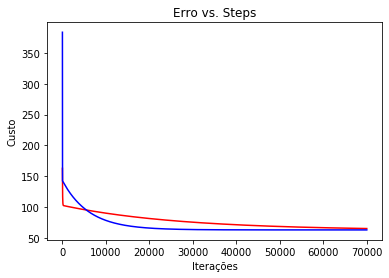

In [20]:
fig, ax = plt.subplots()  
ax.plot(np.arange(nsteps), cost, 'r',label='Linear')  
ax.plot(np.arange(lnsteps), lcost, 'b',label='Logarit.')  
ax.set_xlabel('Iterações')  
ax.set_ylabel('Custo')  
ax.set_title('Erro vs. Steps')  

<hr>
<h1>Vamos agora vizualizar os ajustes aos dados:


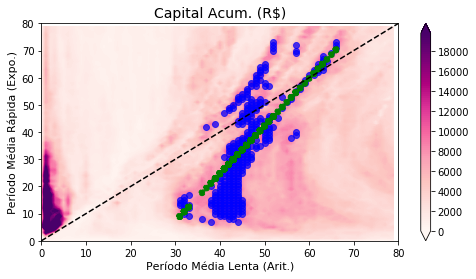

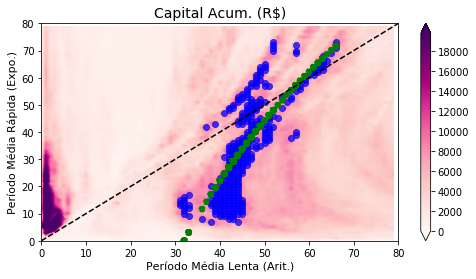

In [21]:
plot_triade2(Capital[:80,:80],TA,EM,2,w0,w1,'lin',x,y)
plot_triade2(Capital[:80,:80],TA,EM,2,lw0,lw1,'log',x,y)

<hr>
<h1>Nota-se</h1>
que os ajustes ficam parecidos, mas com um certo underfitting próximo a PB=30 no ajuste logaritmo, para os quais se prediz PAs que levam a baixo capital acumulado.


Vamos verificar o capital acumulado obtido ao se adotar cada um dos ajustes:

In [22]:
lin_capital=[run_strategy(df,int(A),int(B),10) for A,B in zip(flog(w0,w1,x,'lin'),x)]
log_capital=[run_strategy(df,int(max(A,1)),int(B),10) for A,B in zip(flog(lw0,lw1,x,'log'),x)]

/home/wlademir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/home/wlademir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wlademir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different l

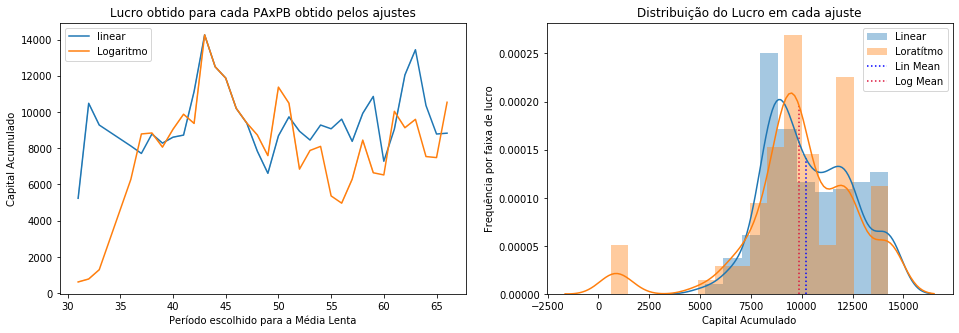

In [23]:
fig, [axs,axw] = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axs=sns.lineplot(x=x,y=np.array(lin_capital)[:,0],ax=axs,label='linear')
axs=sns.lineplot(x=x,y=np.array(log_capital)[:,0],ax=axs,label='Logaritmo')
axs.set_ylabel('Capital Acumulado')
axs.set_xlabel('Período escolhido para a Média Lenta')
axs.set_title('Lucro obtido para cada PAxPB obtido pelos ajustes')

#plt.legend()
axw=sns.distplot(np.array(lin_capital)[:,0],ax=axw,label='Linear')
mean1 = np.median(np.array(lin_capital)[:,0])
kdeline1 = axw.lines[0]
xs1 = kdeline1.get_xdata()
ys1 = kdeline1.get_ydata()
height1 = np.interp(mean1, xs1, ys1)

axw=sns.distplot(np.array(log_capital)[:,0],ax=axw,label='Loratítmo')
mean2 = np.median(np.array(log_capital)[:,0])
kdeline2 = axw.lines[1]
xs2 = kdeline2.get_xdata()
ys2 = kdeline2.get_ydata()
height2 = np.interp(mean2, xs2, ys2)

axw.vlines(mean1, 0, height1, color='blue', ls=':',label='Lin Mean')
axw.vlines(mean2, 0, height2, color='crimson', ls=':',label='Log Mean')
axw.set_xlabel('Capital Acumulado')
axw.set_ylabel('Frequência por faixa de lucro')
axw.set_title('Distribuição do Lucro em cada ajuste')
plt.legend()
    

<hr>
<h1> Observamos que ...</h1>

- O ajuste linear apresentou mediana ligeiramente maior que o ajuste logarítmo, e foi sensivelmente melhor em torno de PB=30-35 e PB=55, aproximadamente.



<hr>

<h1> Para finalizarmos</h1>

Existe a premissa de que sistemas seguidores de tendência, como o investigado aqui, fornece poucos sinais e baixa taxa de acerto, e é portanto fundamental que aquele que decida seguir essa estratégia, o faça em todos os sinais dados num determinado papel.
Caso o investidor decida não tomar esse ou aquele sinal, correrá o risco de perder uma operação que seria responsável por significativa parte do lucro daquela estratégia, o que arruinaria a expectativa matemática positiva esperada.

Vamos investigar agora qual o grau de liberdade um investidor tem de "escolher os sinais", se é que tem algum.

A idéa é:

- comparar o resultado daquele que tomou todos os sinais, com aquele que selecionou uma amostra com uma fração dos sinais dados. Por exemplo, faço aqui uma amostra com 80%. Ou seja, o investidor deixeou de realizar a operação em 20% dos casos;

Vou usar PB=45 e PA será dado pelo ajuste linear.



<hr>


In [88]:
lin_capital=run_strategy(df,int(w0+w1*45),45,10) 
profit=lin_capital[6]
cap=lin_capital[5]
profit = profit[~np.isnan(profit)]
cap=cap[~np.isnan(cap)]

Farei amostras dos resultados de cada operação, armazenada em profit, e calculo o somatório da amostra. 


10869.368108451366


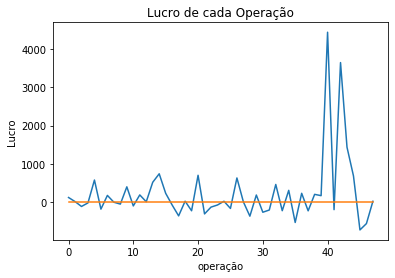

In [26]:
plt.plot(profit)
plt.plot(profit*0)
plt.title('Lucro de cada Operação')
plt.ylabel('Lucro')
plt.xlabel('operação')
CapTot=profit.sum()
print(CapTot)

Executando todos os sinais, obteve-se, para esse par de PA e PB e um STOP=10%, um capital final de CapTot= R$10869.38 reais.

prosseguindo ...

Utilizarei a biblioteca train_test_split do sklearn para montar a amostra.

In [70]:
from sklearn.model_selection import train_test_split
#print(profit)
def monta_amostra(profit, cap,size=0.2):
    soma=np.zeros(1000)
    for i in range(0,len(soma)):
        x_train, x_test, y_train, y_test = train_test_split(profit, cap, test_size =size)
        #print(x_train)
        soma[i]=x_train.sum()
    return soma
soma=monta_amostra(profit,cap,0.2)

<hr>
Agora vamos ver um histograma dos resultados e obter a probabilidade de obtermos uma lucratividade menor que obteríamos se tomássemos todos os sinais.

Utilizo a função  KernelDensity para obtermos a distriubição de probabilidade. 
Para estimar a probabilidade associada ao CapTot, fazemos a integral da função densidade de probabilidade, de -CapTot até CapTot:


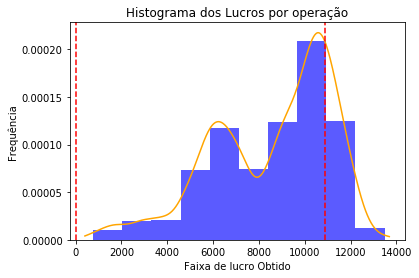

Probabilidade de obtermos resultados inferiores a CapTot: 0.8037786003424057


In [59]:
# Plot the data using a normalized histogram
from sklearn.neighbors import KernelDensity

def acha_Kde(soma,CapTot):
    X=soma[:,np.newaxis]
    x = np.linspace(soma.min() , soma.max() , 500)[:, np.newaxis]
    plt.hist(X[:,0], bins=10, density=True, label='Lunch Time', color='blue', alpha=0.4)
    kde = KernelDensity(kernel='gaussian', bandwidth=400).fit(X)
    kd_vals_soma = np.exp(kde.score_samples(x))
#   Integrando a função kde
    N = 2000
    start_value=-CapTot
    step = ( (CapTot-0.01)- (start_value-0.01) )/ (N - 1)  # Step size
    x = np.linspace(start_value, CapTot, N)[:, np.newaxis]  # Generate values in the range
    kd_vals = np.exp(kde.score_samples(x))  # Get PDF values for each x
    p = np.sum(kd_vals * step)  # Approximate the integral of the PDF
    return X,kde,kd_vals_soma,p

X,kde,kd_vals_soma,p=acha_Kde(soma,CapTot)
plt.hist(X[:,0], bins=10, density=True, label='Lunch Time', color='blue', alpha=0.4)
plt.plot(x, kd_vals_soma, color='orange')
plt.title('Histograma dos Lucros por operação')
plt.ylabel('Frequência')
plt.xlabel('Faixa de lucro Obtido')
plt.axvline(x=0,color='red',linestyle='dashed')
plt.axvline(x=profit.sum(),color='red',linestyle='dashed')
plt.show()
print('Probabilidade de obtermos resultados inferiores a CapTot: {}'.format(p))


<hr>
Agora que temos uma forma de avaliar a probabilidade acima, para uma certa amostra de operações, vamos repetir esse cálculo para amostras diferentes e ver como os resultados se distribuem.

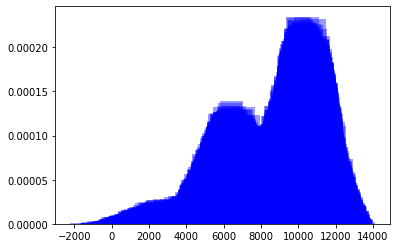

In [81]:
Pfinal=np.zeros(1000)
for i in range(0,1000):
    soma=monta_amostra(profit,cap,0.2)
    X,kde,kd_vals_soma,p=acha_Kde(soma,CapTot)
    Pfinal[i]=p

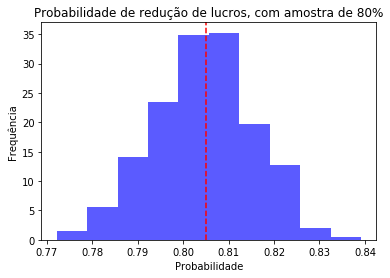

In [82]:
X,kde,kd_vals_soma,p=acha_Kde(Pfinal,np.median(Pfinal))

plt.hist(X[:,0], bins=10, density=True, label='Lunch Time', color='blue', alpha=0.4)
#plt.plot(x, kd_vals_soma, color='orange')
plt.title('Probabilidade de redução de lucros, com amostra de 80%')
plt.ylabel('Frequência')
plt.xlabel('Probabilidade')
#plt.axvline(x=0,color='red',linestyle='dashed')
plt.axvline(x=np.median(Pfinal),color='red',linestyle='dashed')
plt.show()


<hr>
Com 1000 amostras diferentes ficou robusto o resultado de que, ao deixar de operar 20% dos sinais dados entre 2004 e 2022, na Copel, o investidor tem uma probabilidade de 80% de reduzir seus lucros.

Ainda há fôlego para mais uma questão: E quando a amostras de outros tamanhos?
Vejamos ...

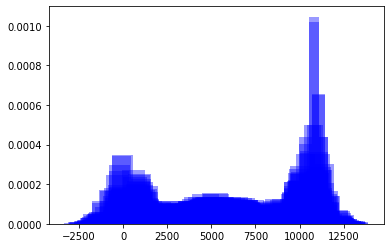

In [83]:
Pfinal=np.zeros(100)
for i in range(1,90):
    soma=monta_amostra(profit,cap,i/100)
    X,kde,kd_vals_soma,p=acha_Kde(soma,CapTot)
    Pfinal[i]=p


Text(0, 0.5, 'Probabilidade de Redução de Lucro')

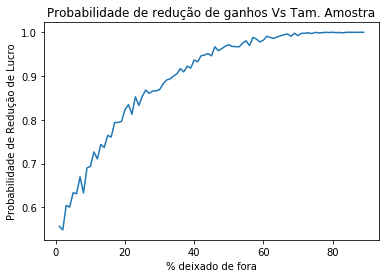

In [79]:
Pfinal[Pfinal==0]=np.NaN

plt.plot(Pfinal)
plt.title('Probabilidade de redução de ganhos Vs Tam. Amostra')
plt.xlabel('% deixado de fora')
plt.ylabel('Probabilidade de Redução de Lucro')

<hr>
<h1> Considerações Finais </h1>

- A estratégia de cruzamento entre as médias produz resultados que são extremamente sensíveis aos períodos adotados. Antes de adotar essa estratégia, é preciso testá-la nas ações de interesse;
- Dois aglomerados de pares (PA,PB) foram identificados e separados com sucesso por método de clusterização, contudo, apenas um deles foi abordado no estudo;
- O ajuste linear apresentou pequena vantagem ao ajuste logarítmo, utilizando-se a técnica de descida do gradiente. Poder-se-ia testar, também, uma biblioteca própria para o ajuste linear e logarítimo;
- O teste de sensibilidade com relação à escolha de quais sinais são tomados ou não mostrou que, deixando-se de tomar 20% dos sinais dados, há uma probabiliade de cerca de 80% de se obter uma lucratividade menor do que se obteria tomando-se todos os sinais. Mesmo reduções menores aumentam substancialmente a probabilidade de redução de ganhos.